# Лекция №5

## На прошлой лекции

[Познакомились с полями в OpenFOAM](#Fields)

[Основы Paraview](#Paraview)

[Узнали про dynamicRefineFvMesh](#dynamicRefineFvMesh)

## План
1. [Процесс дискретизации](#discr)
2. [Метод контрольного объема (Finite Volume Method)](#FVM)
3. [Производная по времени](#ddt)
4. [Источник](#source)
5. [Операторы fvm и fvc в OpenFOAM](#fvof)
6. [Заключение](#finish)

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/basic/laplacianFoam/laplacianFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2017 OpenFOAM Foundation
    Copyright (C) 2019 OpenCFD Ltd.
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    laplacianFoam

Group
    grpBasicSolvers

Description
    Laplace equation solver for a scalar quantity.

    \heading Solver details
    The solver is applicable to, e.g. for thermal diffusion in a solid.  The
    equation is given by:

    \f[
        \ddt{T}  = \div \left( D_T \grad T \right)
    \f]

    Where:
    \vartable
        T     | Scalar field which is solved for, e.g. temperature
        D_T   | Diffusion coefficient
    \endvartable

    \heading Required fields
    \plaintable
        T     | Scalar field which is solved for, e.g. temperature
    \endplaintable

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "fvOptions.H"
#include "simpleControl.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Laplace equation solver for a scalar quantity."
    );

    #include "postProcess.H"

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"

    simpleControl simple(mesh);

    #include "createFields.H"

    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    Info<< "\nCalculating temperature distribution\n" << endl;

    while (simple.loop())
    {
        Info<< "Time = " << runTime.timeName() << nl << endl;

        while (simple.correctNonOrthogonal())
        {
            fvScalarMatrix TEqn
            (
                fvm::ddt(T) - fvm::laplacian(DT, T)
             ==
                fvOptions(T)
            );

            fvOptions.constrain(TEqn);
            TEqn.solve();
            fvOptions.correct(T);
        }

        #include "write.H"

        runTime.printExecutionTime(Info);
    }

    Info<< "End\n" << endl;

    return 0;
}


// ************************************************************************* //
```

## Процесс дискретизации <a name="discr"></a>

<img src="img/cfd.png" width="500" height="200">

[Дискретизация](../books/darwish.pdf) p.112 (87)

<img src="img/discr.png" width="500" height="200">

## Метод контрольного объема (Finite Volume Method) <a name="FVM"></a>

<img src="img/finite_volume.png" width="1000" height="200">

Особенности:
1. Интегральная форма
2. Консервативность
3. 2й порядок по пространству (как правило)

Fluent, FlowVision, StarCCM, Numeca ...

Литература:

[FVM wolfdynamics](../books/wd_fvm.pdf)

[Численные методы решения задач теплообмена и динамики жидкости. Патанкар.](../books/patankar.pdf) 

[Moukalled,Mangani,Darwish The FV Method in CFD. An Advanced Introduction with OpenFOAM and Matlab 2015](../books/darwish.pdf)

[Введение в FVM OpenFOAM site](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes.html)

Уравнение переноса в дифференциальной форме:

$$
\underbrace{\partial{\rho \phi}\over {\partial t}}_{\mathrm{unsteady}} + \underbrace{\nabla \cdot \left(\rho \phi \vec{U} \right)}_{\mathrm{convection}} = \underbrace{\nabla \cdot \left(\Gamma \nabla \phi \right)}_{\mathrm{diffusion}} + \underbrace{S_\phi}_{\mathrm{source}}
$$

Уравнение переноса в интегральной форме:

$$
\int_V {\partial{\rho \phi}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV + \int_V S_\phi dV
$$

$dV$ - элементарный объем (ячейка сетки) "картинка ячейки"

$\phi$ - объемное поле (volScalarField) ($\rho,\rho U,\rho E, T$)

$\vec U$ - объемное поле скорости

$\rho$ - объемное поле плотности

$\Gamma$ - объемное поле коэффициента диффузии

$S_\phi$ - объемное поле источника

<img src="img/cell.png" width="300" height="200">

[FVM wolfdynamics](../books/wd_fvm.pdf) p.12

[ProgrammerGuide](../books/OFpg.pdf) p.25

Производная по времени:

$$\int_V {\partial{\rho \phi}\over {\partial t}} dV \approx ({\partial{\rho \phi}\over {\partial t}})_P V_p$$

Источник:
$$\int_V S_\phi dV \approx S_{\phi P} V_P$$

Источник и производная по времени: только объемные поля (volScalarField), нет связи с соседними ячейками

Теорема Остроградского-Гаусса:

$$\int_V \left( \nabla \cdot \vec u \right) dV = \oint_S \left( \vec{n} \cdot \vec u \right) dS \approx
\sum\limits_{face} \left( \vec{n} \cdot \vec u \right)_f S_f
$$

Конвекция:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

Диффузия:

$$\int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV \approx
\sum\limits_{face} \left(\Gamma \nabla \phi  \cdot \vec{n} \right)_f S_f$$

Конвекция и диффузия: поля на гранях (surfaceScalarField), связь с соседними ячейками

[Связть Сетки и СЛАУ](../books/darwish.pdf) p.119 (94)

<img src="img/mesh_slau.png" width="500" height="200">

СЛАУ:

$$
\begin{bmatrix} a_{11} & a_{12} & \dots & a_{1m} \\ a_{21} & a_{22} & \dots & a_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m1} & a_{m2} & \dots & a_{mm} \end{bmatrix} \begin{bmatrix} \phi_{1}^{n+1} \\ \phi_{2}^{n+1} \\ \vdots \\ \phi_{m}^{n+1} \end{bmatrix} = \begin{bmatrix} b_{1} \\ b_{2} \\ \vdots \\ b_{m} \end{bmatrix}
$$

$n$ - индекс по времени

$m$ - номер ячейки

$$
A \vec{\phi} = \vec{b}
$$
$A$ - коэффициенты матрицы

$\vec{\phi}^{n+1}$ - неизвестное объемное поле величины

$\vec{b}(\phi^{n, n-1 ...}) $ - правая часть (объемное поле)

## Производная по времени <a name="ddt"></a>

$$\int_V {\partial{\rho \phi}\over {\partial t}} dV \approx ({\partial{\rho \phi}\over {\partial t}})_P V_p$$

[Blazek](../books/blazek.pdf) p. 176 (167)

Явные и неявные схемы, универсальная форма записи схемы 2-го порядка для стационарной сетки:

$$\frac{V_P}{\Delta t_P}\Delta \phi_P^n=\frac{-\beta }{1+\omega }\vec R_P^{n+1}-\frac{1-\beta }{1+\omega }R_P^n+\frac{\omega}{1+\omega }\frac{V_P}{\Delta t_P}\Delta \phi_P^{n-1}$$

$$\Delta \phi_P^n=\phi_P^{n+1}-\phi_P^n$$

$\beta , \omega $- параметры, контролирующие точность (порядок) и «неявность» схемы.

### Явные схемы

Все значения зависят только от текущего временного шага, просты в реализации.  $\beta =0,\omega =0$ 
$$\frac{V_P}{\Delta t_P}\Delta \phi_P^n=\frac{-\beta }{1+\omega }\vec R_P^{n+1}-\frac{1-\beta }{1+\omega }R_P^n+\frac{\omega}{1+\omega }\frac{V_P}{\Delta t_P}\Delta \phi_P^{n-1}$$
$$\Delta \phi_P^n=-R_P^n \frac{\Delta t_P}{V_P}$$

[ProgrammerGuide](../books/OFpg.pdf) p.37

Самая простая схема Эйлера (Euler) 1-го порядка:
$$ \frac{\partial \phi}{\partial t}=\frac{\phi^{n+1}-\phi^n}{\Delta t} $$

Противопотоковая схема Эйлера (backward) 2-го порядка:
$$\frac{\partial \phi}{\partial t}=\frac{3\phi^{n+1}-4\phi^n+\phi^{n-1}}{2\Delta t}$$

Схема Кранка-Николсона (CrankNicolson) 2-го порядка точности:
$$ \frac{\partial \phi}{\partial t}=\frac{\phi^{n+1}-\phi^{n-1}}{2\Delta t} $$

Очень популярны явные многошаговые методы Рунге-Кутты и гибридные многошаговые методы.

### Многошаговые методы Рунге-Кутты

$$\phi_P^{(0)}=\phi_P^n,\\\phi_P^{(1)}=\phi_P^{(0)}-\alpha _1\frac{\Delta
t_P}{V_P}R_P^{(0)},\\\phi_P^{(2)}=\phi_P^{(0)}-\alpha _2\frac{\Delta t_P}{V_P}R_P^{(1)},\\\vdots
\\\phi_P^{n+1}=\phi_P^{(m)}=\phi_P^{(0)}-\alpha _m\frac{\Delta t_P}{V_P}R_P^{(m-1)},\\{}$$

$\alpha _1\cdots \alpha _m$- некоторые коэффициенты.

Требуют минимум затрат памяти (не нужно хранить данные с прошлого шага). Увеличивают максимальный шаг по
времени, стабильность схемы.

Требуется  $\alpha _m=1$ , для второго порядка  $\alpha _{m-1}=1/2$ . Пригодны для противопотоковых схем на
структурированных и неструктурированных сетках. Для схем с центральной разность больше используются гибридные
многошаговые методы. На ударной волне предпочтительно использовать схему 1 порядка, иначе — осцилляции.

Недостаток — шаг по времени зависит от характеристик уравнения и геометрии сетки. Существует предельное число
Куранта, которое ограничивает стабильность схемы.

<img src="img/rkexp.png" width="500" height="200">

### Неявные схемы

[Blazek](../books/blazek.pdf) p. 176 (167)

Подробно в диффузии и конвекции

## Источник <a name="source"></a>

$$\int_V S_\phi dV \approx S_{\phi P} V_P = S_{\phi PC} V_P + S_{\phi P}(\phi) V_P $$

Случается, что в течениях с химическими реакциями и турбулентностью, источниковый член  $S$- много больше
остальных. Время изменения источникового члена много меньше характерного времени течения  $\frac{\Delta
t_{\mathit{flow}}}{\Delta t_{\mathit{source}}}\rightarrow \infty $.

Увеличивается жесткость системы — отношение максимального к минимальному значений собственных векторов 
$\frac{\lambda _{\mathit{max}}}{\lambda _{\mathit{min}}}$ или отношение максимального к минимальному характерных
масштабов времени.

Использование многошаговых явных схем к жестким системам — смягчает условие на шаг по времени, однако установление
происходит медленнее. Некоторые решения не дают корректного результата. Предложен неявный путь аппроксимации
источниковых членов.

$$S^{n+1}\approx S^n+\frac{\partial S}{\partial T}(T^{n+1}-T^n)$$

«Точечно неявная аппроксимация» — зависит только от значения в центре контрольного объема.

Более продуманным решением является использование неявных схем Рунге-Кутты (Розенброка) — более стабильные, но
требуют затраты на обращение матриц.

## Операторы fvm и fvc в OpenFOAM <a name="fvof"></a>


[ProgrammerGuide](../books/OFpg.pdf) p.35

[FiniteVolume OF Doxygen](https://www.openfoam.com/documentation/guides/latest/api/namespaceFoam_1_1fv.html)

В OpenFOAM существуют стандартные операторы производных: $\frac{\partial }{\partial t},\frac{\partial ^2}{\partial
t^2},(\nabla \cdot \ ),\nabla $, которые возвращают коэффициенты СЛАУ вида:  $A\vec x^{n+1}=\vec b(\vec x^n)$, где 
$\vec x^{n+1}$ - поле искомой переменной (например  $T$ ) на новом слое по времени ,  $\vec b(\vec x^n)$ - правая часть
СЛАУ (входят все величины, зависящие от предшествующих шагов по времени:  $n,n-1...$)

fvm — неявная аппроксимация (возвращает коэффициенты системы линейных уравнений  $A$ и $\vec b$).

fvc — явная аппроксимация (возвращается вектор правой части СЛАУ -  $\vec b$).

Пример кода, использования операторов производной по времени и источникового члена:

$$\frac{\partial T}{\partial t} V_P +S_{P}(T) T V_P = 0 $$

```c++
while(runTime.run()) // цикл по времени (заканчивается по критерию остановки
{
runTime++; // переход к следующей итерации по времени 
    
//TEqn — СЛАУ для поля  T (volScalarField)

//fvm::ddt(T) — аппроксимация производной по времени

//fvm::Sp(S, T) — аппроксимация источника, S - объемное поле volScalarField

fvScalarMatrix TEqn ( fvm::ddt(T) + fvm::Sp(S, T) ); //- инициализация СЛАУ

TEqn.solve();// - решение СЛАУ (результат записывается в T!!!)

runTime.write(); // запись всех полей из регистра
}
```

Эйлер 1й порядок: 
$$ \frac{\partial T}{\partial t} V_P=\frac{T^{n+1}-T^n}{\Delta t} V_P $$

fvm::ddt(T) - возвращает матрицу А (коэффициенты на диагонали) : $\frac{V_P}{\Delta t}$ + b : $\frac{V_P}{\Delta t} T^n$
        
$$S_{P}(T) T V_P $$

fvm::Sp(S, T) - возвращает A (коэффициенты на диагонали) : $S V_P $

* fvm::Su(S, T) - возвращает b
* fvm::SuSp(S, T) - возвращает A и b (в зависимости от знака S в конкретной ячейке)

Все схемы для аппроксимации производных задаются в файле system/fvSchemes
```c++
ddtSchemes
{
default Euler; // backward;
}
```

Метод решения СЛАУ задается в файле system/fvSolution
```c++
solvers
{
    T
    {
    solver diagonal; // PCG
    }
}
```

[OF Doxygen ddt](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-time.html)

In [ ]:
!ls $WM_PROJECT_DIR/src

In [ ]:
!ls $WM_PROJECT_DIR/src/finiteVolume

In [ ]:
!ls $WM_PROJECT_DIR/src/finiteVolume/finiteVolume

In [ ]:
!ls $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/fvc

In [ ]:
!ls $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/fvm

In [ ]:
!cat $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/fvc/fvcSup.C

In [ ]:
!cat $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/fvm/fvmSup.C

In [ ]:
!ls $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/ddtSchemes

Рунге-Кутты в OpenFOAM:
* [dbnsFoam](https://github.com/Unofficial-Extend-Project-Mirror/foam-extend-foam-extend-3.2/blob/master/applications/solvers/compressible/dbnsFoam/dbnsFoam.C)
* [explicitRhoFoam](https://github.com/OpenQBMM/OpenQBMM/tree/master/applications/solvers/compressible/explicitRhoFoam)
* ode OpenFOAM

## OpenFOAM example <a name="OFrelax"></a>

Задача Коши для уравнения релаксации:
$$ \frac{\partial T}{\partial t} =\frac{T_e - T}{\tau}$$

$$ T(t=0) = T_0$$

Решение:

$$T = T_e+(T_0-T_e)e^{-t/\tau}$$

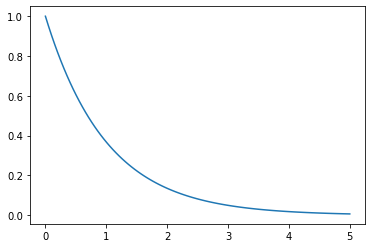

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
T_e = 0
T_0 = 1
tau = 1
t = np.linspace(start=0, stop=5, num=100)
T = T_e+(T_0 - T_e)*math.e**(-t/tau)
plt.plot(t, T)
plt.show()

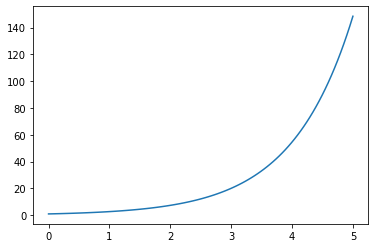

In [2]:
T = T_e+(T_0 - T_e)*math.e**(t/tau)
plt.plot(t, T)
plt.show()

In [ ]:
#!cat relax_eq/relax_eq.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | Copyright (C) 2011-2016 OpenFOAM Foundation
     \\/     M anipulation  |
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    relax equation


\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "IFstream.H"
#include "OFstream.H"
#include "IOmanip.H"
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
  argList::addOption
    (
        "T_0",
	"scalar",
        "initial temperature"
    );
  argList::addOption
    (
        "T_e",
	"scalar",
        "equilibrium temperature"
    );
  argList::addOption
    (
        "tau",
	"scalar",
        "relax time"
    );
  argList::addOption
    (
        "theta",
	"scalar",
        "implicit/explicit coeff RHS [0 - 1] 1 - full implicit, 0 - full explicit"
    );
  
#include "setRootCase.H"
#include "createTime.H"
#include "createMesh.H"

   scalar T_0 = 1.0;
   scalar T_e = 0.0;
   scalar tau = 1.0;
   scalar theta = 0.5;

 if (args.readIfPresent("T_0", T_0))
    {
       Info << "T_0 = " << T_0 << endl;
    }
 if (args.readIfPresent("T_e", T_e))
    {
       Info << "T_e = " << T_e << endl;
    }
 if (args.readIfPresent("tau", tau))
    {
       Info << "tau " << tau << endl;
    }
 if (args.readIfPresent("theta", theta))
    {
       Info << "theta " << theta << endl;
    }
 
 volScalarField T                         // vol - поле в ячейках Scalar - скалярное
    (
     IOobject
     (
      "T",                                // название объекта в регистре
      runTime.timeName(),                    // время
      mesh,                                  // регистр объектов
      IOobject::NO_READ,                     // опция чтения
      IOobject::AUTO_WRITE                   // опция записи
      ),
     mesh,                                   // сетка 
     dimensionedScalar("T", dimTemperature, T_0) // начальное размерное значение
     );

 volScalarField T_0_v                         // vol - поле в ячейках Scalar - скалярное
    (
     IOobject
     (
      "T_0_v",                                // название объекта в регистре
      runTime.timeName(),                    // время
      mesh,                                  // регистр объектов
      IOobject::NO_READ,                     // опция чтения
      IOobject::AUTO_WRITE                   // опция записи
      ),
     mesh,                                   // сетка 
     dimensionedScalar("T_0", dimTemperature, T_0) // начальное размерное значение
     );
 
 volScalarField T_theory                         // vol - поле в ячейках Scalar - скалярное
    (
     IOobject
     (
      "T_theory",                                // название объекта в регистре
      runTime.timeName(),                    // время
      mesh,                                  // регистр объектов
      IOobject::NO_READ,                     // опция чтения
      IOobject::AUTO_WRITE                   // опция записи
      ),
     mesh,                                   // сетка 
     dimensionedScalar("T_theory", dimTemperature, T_0) // начальное размерное значение
     );

 volScalarField rTau                         // vol - поле в ячейках Scalar - скалярное
    (
     IOobject
     (
      "rTau",                                // название объекта в регистре
      runTime.timeName(),                    // время
      mesh,                                  // регистр объектов
      IOobject::NO_READ,                     // опция чтения
      IOobject::AUTO_WRITE                   // опция записи
      ),
     mesh,                                   // сетка 
     dimensionedScalar("rTau", dimless/dimTime, 1.0/tau) // начальное размерное значение
     );

 volScalarField T_e_v                         // vol - поле в ячейках Scalar - скалярное
    (
     IOobject
     (
      "T_e",                                // название объекта в регистре
      runTime.timeName(),                    // время
      mesh,                                  // регистр объектов
      IOobject::NO_READ,                     // опция чтения
      IOobject::AUTO_WRITE                   // опция записи
      ),
     mesh,                                   // сетка 
     dimensionedScalar("T_e", dimTemperature, T_e) // начальное размерное значение
     );
 
  while(runTime.loop()) // цикл по времени
    {
      Info<< "Time = " << runTime.timeName() << nl << endl;
      T_theory = T_e_v+(T_0_v - T_e_v)*Foam::exp(-runTime.value()/tau);
      fvScalarMatrix TEqn
	(
	 fvm::ddt(T) // unsteady
	 ==
	 fvc::Su(rTau*T_e_v, T) // constant source
	 
	 -fvm::Sp(rTau*theta, T) // implicit source
	 -fvc::Sp(rTau*(1.0 - theta), T) // explicit source
	 // - -fvm::SuSp(rTau, T) // sign exp/imp source
	 
	 );
      // first step only
      if(runTime.value() == runTime.deltaTValue())
	{
	  // A*psi = source
	  Info << "TEqn.A(): " << TEqn.A() << endl;
	  Info << "TEqn.source(): " << TEqn.source() << endl;
	  Info << "TEqn.psi(): " << TEqn.psi() << endl;
	  Info << "TEqn.D(): " << TEqn.D() << endl;
	
	  Info << "TEqn.solverDict(): " << TEqn.solverDict() << endl;
	}
      TEqn.solve();
      if(runTime.value() == runTime.deltaTValue())
	{
	  Info << "TEqn.psi(): " << TEqn.psi() << endl;
	}

      runTime.write();
    }
    return 0;
}
```


In [3]:
!ls relax_eq/test

0.5_0.5.png  0.5_1.png	  1.5_0.png  constant
0.5_0.png    1.5_0.5.png  1.5_1.png  system


In [4]:
!cat relax_eq/test/system/blockMeshDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      blockMeshDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

scale   1;

vertices
(
    (0 0 0)
    (1 0 0)
    (1 1 0)
    (0 1 0)
    (0 0 1)
    (1 0 1)
    (1 1 1)
    (0 1 1)
);

blocks
(
    hex (0 1 2 3 4 5 6 7) (1 1 1) simpleGrading (1 1 1)
);

edges
(
);

boundary
(
    movingWall
    {
       

In [5]:
!cat relax_eq/test/system/fvSchemes

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      fvSchemes;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

ddtSchemes
{
  default         Euler; // CrankNicolson 0.5; //backward; //
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;

}

laplacianSchemes
{
    default         Gauss linear corrected;
}

interpola

In [6]:
!cat relax_eq/test/system/fvSolution

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      fvSolution;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

solvers
{
    T
    {
        solver          diagonal;
    }

}



// ************************************************************************* //


In [7]:
!cat relax_eq/test/system/controlDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      controlDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

application     pisoFoam;

startFrom       startTime;

startTime       0;

stopAt          endTime;

endTime         6;

deltaT          1.5;

writeControl    timeStep;

writeInterval   1;

purgeWrite      0;

writeFormat     ascii;

writePrecis

In [9]:
!wmake relax_eq/

wmake relax_eq
Making dependency list for source file relax_eq.C
g++ -std=c++11 -m64 -pthread -DOPENFOAM=2012 -DWM_DP -DWM_LABEL_SIZE=32 -Wall -Wextra -Wold-style-cast -Wnon-virtual-dtor -Wno-unused-parameter -Wno-invalid-offsetof -Wno-attributes -Wno-unknown-pragmas  -O3  -DNoRepository -ftemplate-depth-100 -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/finiteArea/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/finiteVolume/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/meshTools/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/dynamicMesh/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/dynamicFvMesh/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/sampling/lnInclude  -iquote. -IlnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/OpenFOAM/lnInclude -I/home/kuvv/OpenFOAM/OpenFOAM-v2012/src/OSspecific/POSIX/lnInclude   -fPIC -c relax_eq.C -o Make/linux64GccDPInt32Opt/relax_eq.o
g++ -std=c++11 -m64 -pthread -DOPENFOAM=2012 -DWM_DP -DWM_LABEL_SIZE=32 -Wall -Wextra -Wold-style-cast 

In [10]:
!relax_eq -case relax_eq/test/

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : relax_eq -case relax_eq/test/
Date   : Oct 09 2021
Time   : 12:38:32
Host   : kuvv-PS63-Modern-8M
PID    : 15140
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_5/relax_eq/test
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using

Результаты:

<table><tr>
<td> <img src="relax_eq/test/0.5_0.png" width="500" height="200"> </td>
<td> <img src="relax_eq/test/0.5_0.5.png" width="500" height="200"> </td>
<td> <img src="relax_eq/test/0.5_1.png" width="500" height="200"> </td>
</tr></table>

<table><tr>
<td> <img src="relax_eq/test/1.5_0.png" width="500" height="200"> </td>
<td> <img src="relax_eq/test/1.5_0.5.png" width="500" height="200"> </td>
<td> <img src="relax_eq/test/1.5_1.png" width="500" height="200"> </td>
</tr></table>

## Заключение <a name="finish"></a>

1. [Процесс дискретизации](#discr)
2. [Метод контрольного объема (Finite Volume Method)](#FVM)
3. [Производная по времени](#ddt)
4. [Источник](#source)
5. [Операторы fvm и fvc в OpenFOAM](#fvof)

## В следующей серии ...

Диффузия, Лаплассиан!

<table><tr>
<td> <img src="img/diff.jpg" width="500" height="200"> </td>
<td> <img src="img/lap.jpg" width="400" height="200"> </td>
</tr></table>
